In [21]:
#import common modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path

from Scripts import cotEstimators as ce

# Global plot parameters
plt.rcParams.update({'font.size':20, 'lines.markersize':9})
plt.rcParams.update({'mathtext.fontset':'cm'})
plt.rcParams.update({'font.family':'Times New Roman'})


In [22]:
# import robotic fish data
data_location = Path(r'./PowerAndThrustData.xlsx')

xlsx = pd.ExcelFile(data_location, engine='openpyxl')
sheets = xlsx.sheet_names

In [23]:
roboSalmon_df = xlsx.parse(sheet_name=sheets[0])
UVTunabot_df = xlsx.parse(sheet_name=sheets[1])

In [24]:
def average_thrust(data, coeffs, case):
    St = data['Strouhal'].values
    vel = data['Velocity'].values
    freq = data['Frequency'].values

    Re = data['Re'].values

    St_wave = np.multiply(St**2, 1 - np.divide(vel, freq*coeffs['lamda']))

    if case == 'carangiform':
        xi_lamda = coeffs['beta1'] * (1 - np.exp(-coeffs['beta2'] * (coeffs['lamda-L'] - coeffs['lamda0-L'])))
    else:
        xi_lamda = coeffs['beta1'] * coeffs['lamda-L']**2 + coeffs['beta2'] * coeffs['lamda-L'] + coeffs['lamda0-L']

    CT = np.multiply(xi_lamda * (1 - (coeffs['d1']/np.sqrt(Re))), St_wave) - ((coeffs['d2']/np.sqrt(Re)) * coeffs['FB'])

    return Re, CT


In [25]:
def calc_cot(CT, density, dataframe, S_t):
    return np.divide(dataframe['Electrical Power'] + (CT * 0.5 * density * dataframe['Velocity']**3 * S_t), dataframe['Velocity'])  


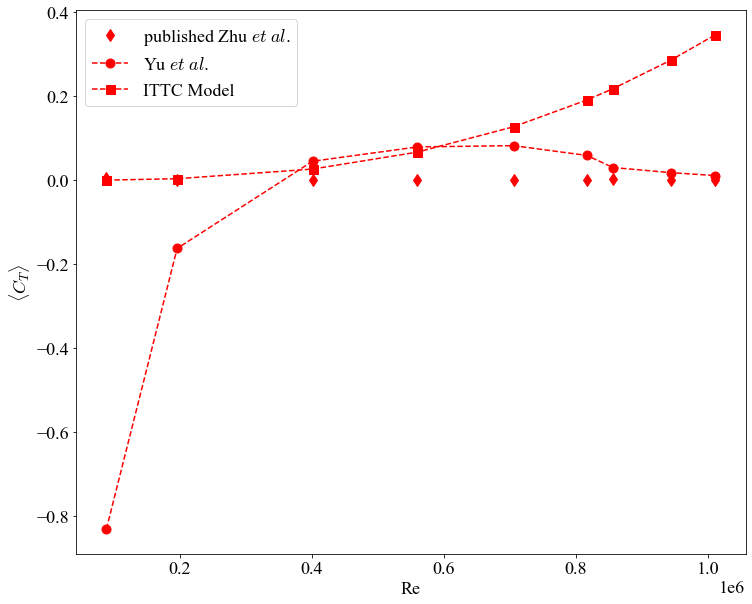

In [26]:
# define some constants for the modeling
density = 998.3
kinVisc = 1.0035e-6

case_coeffs = {}

robots = ['roboSalmon', 'UVTunabot']

L = [0.9, 0.255]
D = [0.14, 0.0492]
lam = [0.9, 0.255]
M = [4.9, 0.306]
S_t = [0.01, 0.0016]
efficiency = [0.8, 0.8]


CT = {robots[0]:{}, robots[1]:{}}
CoT = {robots[0]:{}, robots[1]:{}}

for i, frame in enumerate([roboSalmon_df, UVTunabot_df]):

    case_coeffs['carangiform'] = {'length':L[i], 'beta1':3.61, 'beta2':1.28, 'lamda0-L':0.52, 'lamda':lam[i], 'lamda-L':L[i], 'd1':11.2, 'd2':3.87, 'FB':(1 + (1.5 * (D[i]/L[i])**1.5) + (7 * (D[i]/L[i])**3)), 'xi':1.346}
    
    CT[robots[i]]['Re'], CT[robots[i]]['CT'] = average_thrust(frame, case_coeffs['carangiform'], 'carangiform')
    CT[robots[i]]['Exp'] = frame['CT'].values

    CoT[robots[i]]['modeled'] = calc_cot(CT[robots[i]]['CT'], density, frame, S_t[i])
    CoT[robots[i]]['Exp'] = frame['COT']

    ITTC_prop_power = ce.ITTC_pp(L[i]/D[i], S_t[i], L[i], efficiency[i], 1e-6, density, frame['Velocity'].values)
    CT[robots[i]]['ITTC'] = ITTC_prop_power
    CoT[robots[i]]['ITTC'] = np.divide(frame['Electrical Power'] + ITTC_prop_power, frame['Velocity'])

plt.rcParams.update({'font.size':18})
fig1, ax1 = plt.subplots(figsize=(12,10), facecolor='w')
#ax2 = ax1.twinx()

ax1.plot(CT['UVTunabot']['Re'], CT['UVTunabot']['Exp'], 'rd', label='published ' + 'Zhu $\it{et\;al.}$')
ax1.plot(CT['UVTunabot']['Re'], CT['UVTunabot']['CT'], 'ro--', label='Yu $\it{et\;al.}$')
ax1.plot(CT['UVTunabot']['Re'], CT['UVTunabot']['ITTC'], 'rs--', label='ITTC Model')

# ax2.plot(CT['roboSalmon']['Re'], CT['roboSalmon']['CT'], 'bo--', label='RoboSalmon' + ' modeled')
# ax2.plot(CT['roboSalmon']['Re'], CT['roboSalmon']['Exp'], 'bd', label='RoboSalmon' + ' experiment')

ax1.set_xlabel('Re')
ax1.set_ylabel('$\\langle C_T \\rangle $')
# ax2.set_ylabel('$\\langle C_T \\rangle $ RoboSalmon')
ax1.legend()
# ax2.legend(bbox_to_anchor=(0.75, 0.5))

fig1.savefig('CT_Yu_UVTunabot.pdf', facecolor='w', dpi=300)

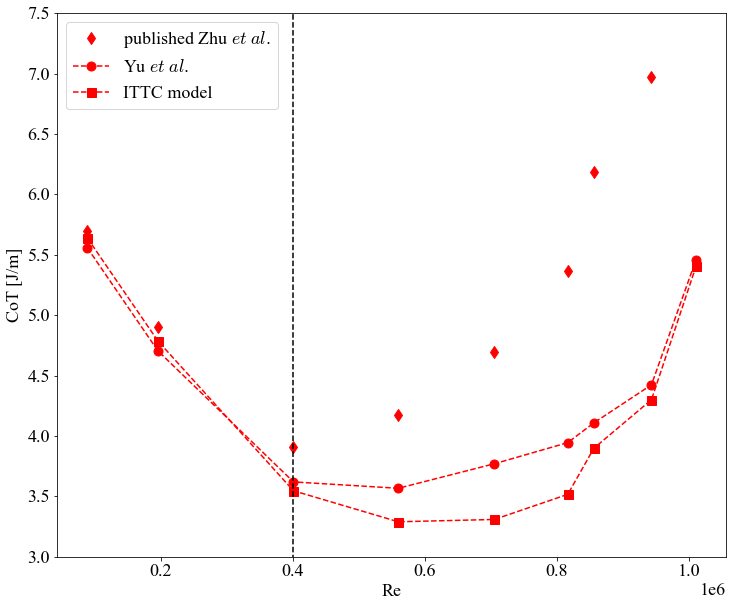

In [27]:
fig2, ax2 = plt.subplots(figsize=(12,10), facecolor='w')
#ax3 = ax2.twinx()

ax2.plot(CT['UVTunabot']['Re'], CoT['UVTunabot']['Exp'], 'rd', label='published ' + 'Zhu $\it{et\;al.}$')
ax2.plot(CT['UVTunabot']['Re'], CoT['UVTunabot']['modeled'], 'ro--', label='Yu $\it{et\;al.}$')
ax2.plot(CT['UVTunabot']['Re'], CoT['UVTunabot']['ITTC'], 'rs--', label='ITTC model')

# ax3.plot(CT['roboSalmon']['Re'], CoT['roboSalmon']['modeled'], 'bo--', label='RoboSalmon' + ' modeled')
# ax3.plot(CT['roboSalmon']['Re'], CoT['roboSalmon']['Exp'], 'bd', label='RoboSalmon' + ' experiment')

min = np.argmin(CoT['UVTunabot']['Exp'])

ax2.plot([CT['UVTunabot']['Re'][min], CT['UVTunabot']['Re'][min]], [0, 10], 'k--')

ax2.set_xlabel('Re')
ax2.set_ylabel('CoT [J/m]')
ax2.set_ylim([3.0, 7.5])
# ax3.set_ylabel('CoT [J/m] RoboSalmon')
ax2.legend(loc=2)
# ax3.legend(bbox_to_anchor=(0.7, 0.75))

fig2.savefig('CoT_Yu_UVTunabot.pdf', facecolor='w', dpi=300)

In [24]:
rmsd_ct = np.sqrt(np.sum((CT['UVTunabot']['CT']-CT['UVTunabot']['Exp'])**2)/len(CT['UVTunabot']['CT']))
rmsd_cot = np.sqrt(np.sum((CoT['UVTunabot']['modeled']-CoT['UVTunabot']['Exp'])**2)/len(CoT['UVTunabot']['modeled']))

print(rmsd_ct, rmsd_cot)

0.28723461315433824 1.8192513363747758


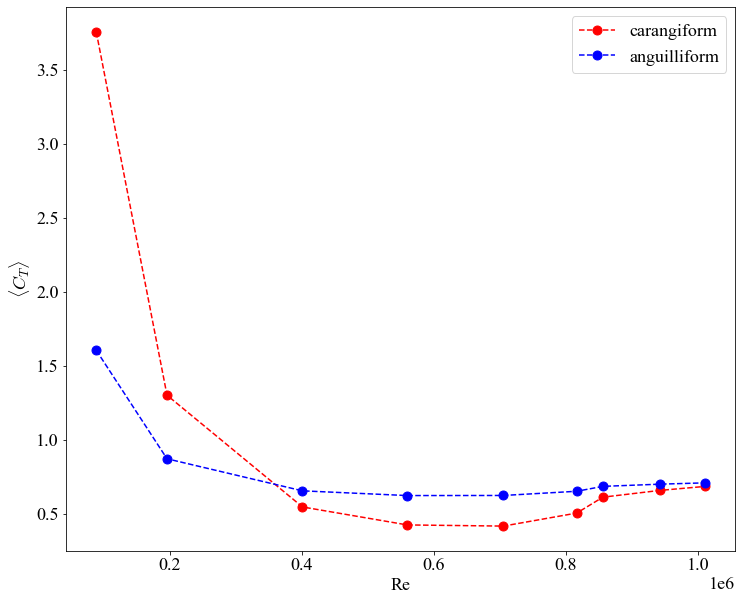

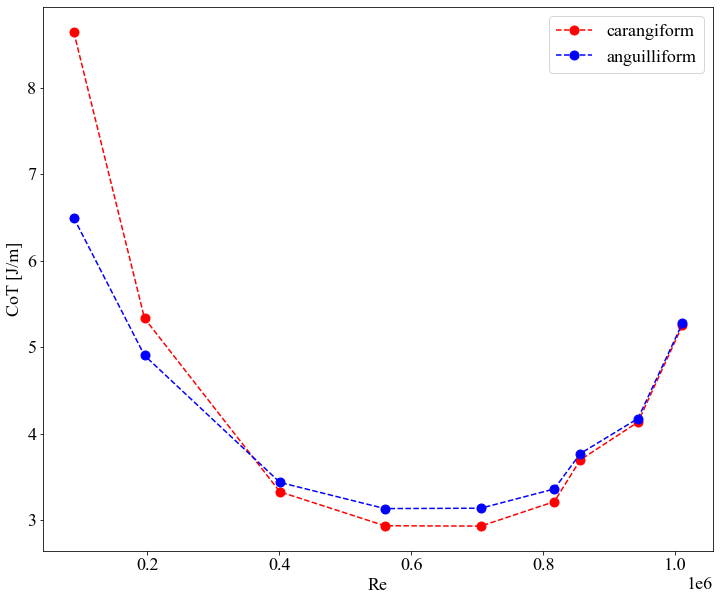

In [25]:
# define some constants for the modeling
density = 998.3
kinVisc = 1.0035e-6

case_coeffs = {}

robots = ['carangiform', 'anguilliform']

L = 0.255
D = 0.0492

SR = D/L

A = 0.1
lam = 0.255

M = 0.306
S_t = 0.0016
efficiency = 0.8

case_coeffs['carangiform'] = {'length':L, 'beta1':3.61, 'beta2':1.28, 'lamda0-L':0.52, 'lamda':lam, 'lamda-L':lam/L, 'd1':11.1, 'd2':3.87, 'FB':(1 + (1.5 * (SR)**1.5) + (7 * (SR)**3)), 'xi':1.346}
case_coeffs['anguilliform'] = {'length':L, 'beta1':3.13, 'beta2':-4.82, 'lamda0-L':3.32, 'lamda':lam, 'lamda-L':lam/L, 'd1':5.6, 'd2':3.94, 'FB':(1 + (1.5 * (2*A/lam)**1.5) + (7 * (2*A/lam)**3)), 'xi':1.463}

CT = {robots[0]:{}, robots[1]:{}}
CoT = {robots[0]:{}, robots[1]:{}}

for i, robot in enumerate(robots):

    frame = UVTunabot_df
    
    CT[robot]['Re'], CT[robot]['CT'] = average_thrust(frame, case_coeffs[robot], robot[i])
    CT[robot]['Exp'] = frame['CT'].values

    CoT[robot]['modeled'] = calc_cot(CT[robot]['CT'], density, frame, S_t, efficiency)
    CoT[robot]['Exp'] = frame['COT']

fig3, ax3 = plt.subplots(figsize=(12,10), facecolor='w')
fig4, ax4 = plt.subplots(figsize=(12,10), facecolor='w')

ax3.plot(CT['carangiform']['Re'], CT['carangiform']['CT']+0.75, 'ro--', label='carangiform')
ax3.plot(CT['anguilliform']['Re'], CT['anguilliform']['CT']+0.75, 'bo--', label='anguilliform')

ax4.plot(CT['carangiform']['Re'], CoT['carangiform']['modeled'], 'ro--', label='carangiform')
ax4.plot(CT['anguilliform']['Re'], CoT['anguilliform']['modeled'], 'bo--', label='anguilliform')


ax3.set_xlabel('Re')
ax3.set_ylabel('$ \\langle C_T \\rangle $')
ax3.legend()

ax4.set_xlabel('Re')
ax4.set_ylabel('CoT [J/m]')
ax4.legend()

#fig3.savefig('CT_2_modes_carang.pdf', facecolor='w', dpi=300, bbox_inches='tight')
#fig4.savefig('CoT_2_modes_carang.pdf', facecolor='w', dpi=300, bbox_inches='tight')

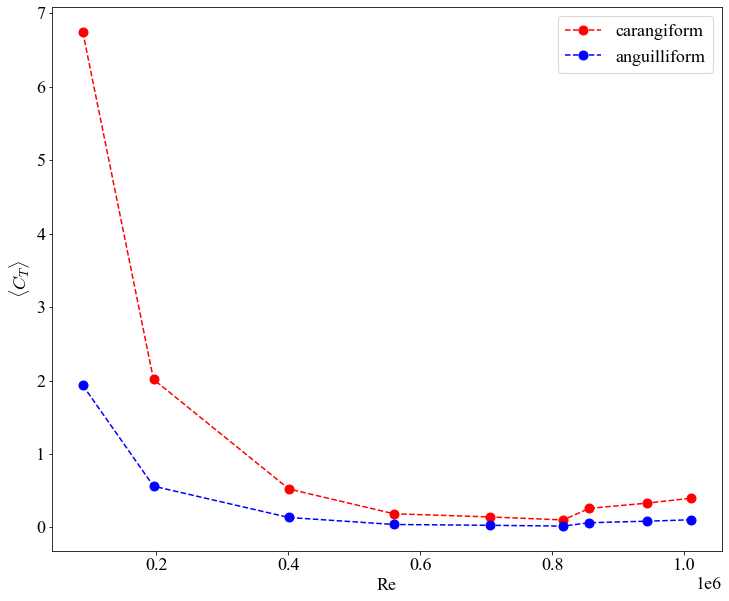

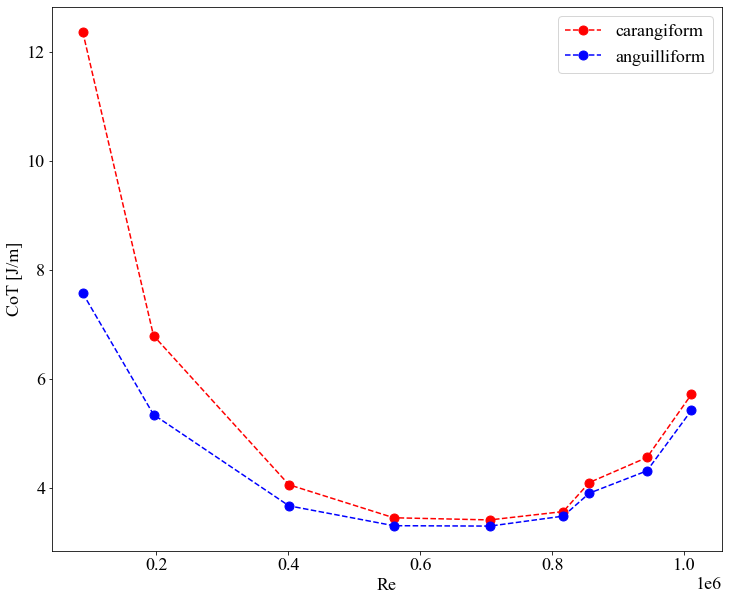

In [26]:
robots = ['carangiform', 'anguilliform']

L = 0.255
D = 0.0492

SR = D/L

lam = 0.35
A = 0.1

M = 0.306
S_t = 0.0016
efficiency = 0.8

case_coeffs['carangiform'] = {'length':L, 'beta1':3.61, 'beta2':1.28, 'lamda0-L':0.52, 'lamda':lam, 'lamda-L':lam/L, 'd1':11.1, 'd2':3.87, 'FB':(1 + (1.5 * (SR)**1.5) + (7 * (SR)**3)), 'xi':1.346}
case_coeffs['anguilliform'] = {'length':L, 'beta1':3.13, 'beta2':-4.82, 'lamda0-L':3.32, 'lamda':lam, 'lamda-L':lam/L, 'd1':5.6, 'd2':3.94, 'FB':(1 + (1.5 * (2*A/lam)**1.5) + (7 * (2*A/lam)**3)), 'xi':1.463}

CT = {robots[0]:{}, robots[1]:{}}
CoT = {robots[0]:{}, robots[1]:{}}

for i, robot in enumerate(robots):

    frame = UVTunabot_df
    
    CT[robot]['Re'], CT[robot]['CT'] = average_thrust(frame, case_coeffs[robot], robot[i])
    CT[robot]['Exp'] = frame['CT'].values

    CoT[robot]['modeled'] = calc_cot(CT[robot]['CT'], density, frame, S_t, efficiency)
    CoT[robot]['Exp'] = frame['COT']


fig5, ax5 = plt.subplots(figsize=(12,10), facecolor='w')
fig6, ax6 = plt.subplots(figsize=(12,10), facecolor='w')

ax5.plot(CT['carangiform']['Re'], CT['carangiform']['CT'], 'ro--', label='carangiform')
ax5.plot(CT['anguilliform']['Re'], CT['anguilliform']['CT'], 'bo--', label='anguilliform')

ax6.plot(CT['carangiform']['Re'], CoT['carangiform']['modeled'], 'ro--', label='carangiform')
ax6.plot(CT['anguilliform']['Re'], CoT['anguilliform']['modeled'], 'bo--', label='anguilliform')

ax5.set_xlabel('Re')
ax5.set_ylabel('$ \\langle C_T \\rangle $')
ax5.legend()

ax6.set_xlabel('Re')
ax6.set_ylabel('CoT [J/m]')
ax6.legend()

#fig5.savefig('CT_2_modes_ang.pdf', facecolor='w', dpi=300, bbox_inches='tight')
#fig6.savefig('CoT_2_modes_ang.pdf', facecolor='w', dpi=300, bbox_inches='tight')